<a href="https://colab.research.google.com/github/Mees-Molenaar/cycling-fantasy-prediction/blob/master/profile_icon_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating the icon of the profile

This notebook uses the Pytorch library to predict the profile_icon of the stage. This icon tells something about the race. If it's flat, hilly, or uphill finish. See this link: https://www.procyclingstats.com/info/profile-score-explained.

The machine learning model used is a residual neural network (ResNet) of 18 layers deep. This is a convolational neural network, and it is trained on profile images scraped of https://www.procyclingstats.com/. 

In classify_profiles.ipynb, the trained model is used to predict the missing profile icons and is later used to create features for the final machine learning model. The final model is used to predict the best performing cyclists for my fantasy league.


In [ ]:
#First the imports
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch.optim as optim

%matplotlib inline

In [ ]:
# And set the device for GPU usage
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
# Set seeding
torch.manual_seed(420)
np.random.seed(420)

In [ ]:
# Mount drive to acces the data
%load_ext autoreload
%autoreload 2
import sys
from google.colab import drive
from pathlib import Path


drive.mount('content/', force_remount=True)
base = Path('/content/content/My Drive/TdF/Profiles')
sys.path.append(str(base))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at content/


In [ ]:
# These are the classes
classes = ['p1', 'p2', 'p3', 'p4', 'p5']

## Functions used for training the model

In [ ]:
# This function reverses the Pytorch.transforms.Normalize(), which is needed to show the tensor as an image.
def reverse_normalization(tensor_in, mean, std):
  std = torch.FloatTensor(std)
  mean = torch.FloatTensor(mean)
  tensor_out = torch.zeros([tensor_in.shape[0], tensor_in.shape[1], tensor_in.shape[2]], dtype=torch.float)
  tensor_out[0] = tensor_in[0] * std[0] + mean[0]
  tensor_out[1] = tensor_in[1] * std[1] + mean[1]
  tensor_out[2] = tensor_in[2] * std[2] + mean[2]
  return tensor_out

In [ ]:
# Show an image from the dataset
def imshow(img):
  normalised = reverse_normalization(img, mean =[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  out = normalised.numpy().transpose((1, 2, 0))
  plt.imshow(out)

In [ ]:
# Show a number of random samples from the dataset
# From this question: https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def show_bunch(dataset, number=5, column='profile_icon'):
  bunch = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=number)
  
  rows = int(np.ceil(number / 5))
  fig, axeslist = plt.subplots(ncols=5, nrows=rows, figsize=(20, 20))

  for ind, data_index in enumerate(bunch):
    image = dataset[data_index]['image']
    normalised = reverse_normalization(image, mean =[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalised.numpy().transpose((1, 2, 0))
    label = dataset[data_index][column]
    axeslist.ravel()[ind].imshow(img)
    axeslist.ravel()[ind].set_title(np.round(label.item(), 2))
    axeslist.ravel()[ind].set_axis_off()

  plt.tight_layout()

In [ ]:
# Makes a new resnet18 model, which is not pretrained. The last linear layer is changed to ouput the same number of layers as classes.
def new_model():
  model = torchvision.models.resnet18(pretrained=False)
  # Make the last linear layer equal to the dimension of classes
  class_number = len(classes)
  lin = model.fc

  new_lin = nn.Sequential(
      nn.Linear(lin.in_features, class_number, bias=True)
  )

  model.fc = new_lin
  return model

In [ ]:
# This function splits the data in a train and test set, it is also optional to add a cross validation set.
# The y_column is needed to create the Dataset, since it has to contain the label.
def test_train_split(df, test, train, cross_valid=None, y_column='profile_icon'):

  train = df.sample(frac=train, random_state=420)
 
  if not cross_valid:
    test = df.drop(train.index)


    test_set = ProfilesDataset(df=test, root_dir='', y_column=y_column, transform=data_transforms['test'])
    train_set = ProfilesDataset(df=train, root_dir='', y_column=y_column, transform=data_transforms['train'])

    return test_set, train_set

  else:
    
    over = df.drop(train.index)

    test_num = len(df) * test
    test_frac = len(over) / test_num

    test = over.sample(frac=test_frac, random_state=420)
    cross_valid = df.drop(test.index)

    test_set = ProfilesDataset(df=test, root_dir='', y_column=y_column, transform=data_transforms['test'])
    train_set = ProfilesDataset(df=train, root_dir='', y_column=y_column, transform=data_transforms['train'])
    cross_set = ProfilesDataset(df=cross_valid, root_dir='', y_column=y_column, transform=data_transforms['test']) 

    return test_set, train_set, cross_valid_set

In [ ]:
# Function to train a model.
def train_model(epochs, model, train_loader, test_loader, optimizer, criterion):
  loss_history = []
  val_loss_history = []

  for epoch in range(epochs):

    # Inititiate loss variables
    epoch_loss = 0.0
    epoch_val_loss = 0.0

    print(f'Epoch: {str(epoch + 1)}')

    # Alterate between train and validaton phase
    for phase in ['train', 'val']:

      if phase == 'train':
        model.train(True) # Set model to training mode
        data_loader = train_loader
      else:
        model.train(False) # Set model to evaluate mode
        data_loader = test_loader


      # Loop over the data in batch sizes.
      for i, data in enumerate(data_loader, 0):
        # get the inputs; data is a list of inputs, and y
        inputs, y = data['image'].to(device), data['profile_icon'].to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)   
        loss = criterion(outputs, y)

        # Add loss to each epoch
        if phase == 'train':
          loss.backward()
          optimizer.step()
          epoch_loss = outputs.shape[0] * loss.item()
        else:
          epoch_val_loss += outputs.shape[0] * loss.item()

        scheduler.step()

    epoch_loss /= len(train_set)
    epoch_val_loss /= len(test_set)

    loss_history.append(epoch_loss)
    val_loss_history.append(epoch_val_loss)

    print(f'Epoch {str(epoch)} MSE Train Loss: {str(epoch_loss)} ; Validation Loss: {str(epoch_val_loss)}.')

  print('Finished Training')
  return model, loss_history, val_loss_history

In [ ]:
# Plot the training and validation loss using matplotlib
def show_losses(training_loss, validation_loss):

  np_loss = np.asarray(training_loss)
  np_val_loss = np.asarray(validation_loss)
  plt.plot(np_loss, label='Train loss')
  plt.plot(np_val_loss, label='Validation loss')
  plt.legend()
  plt.ylabel('Mean Squared Error')
  plt.xlabel('Epochs')
  plt.show()

In [ ]:
# Function to show the accuracy of the model.
def accuracy(model, data_loader):
  correct = 0
  total = 0
  with torch.no_grad():
    for ind, data in enumerate(data_loader, 0):
      images = data['image'].to(device)
      labels = data['profile_icon'].to(device)

      outputs=model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = np.round((correct / total * 100), 2)
  print(f'Accuracy of the network is {str(accuracy)}%.')


## Profile DataClass

In [1]:
class ProfilesDataset(torch.utils.data.Dataset):
  'Make a profiles dataset compatible for Pytorch'
  def __init__(self, df, root_dir, y_column, transform=None):
    self.profiles_df = df
    self.root_dir = root_dir
    self.transform = transform
    self.y_column = y_column

  def __len__(self):
    return len(self.profiles_df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.profiles_df.iloc[idx]['img_name'])
    image = Image.open(img_name)
    profile_icon = self.profiles_df.iloc[idx][self.y_column]

    sample = {'image': image, 'profile_icon': torch.tensor(profile_icon, dtype=torch.long)}

    try:
      if self.transform:
        sample['image'] = self.transform(sample['image'])
    except:
      profile_race = self.profiles_df.iloc[idx]['race']
      print(f'Deze geeft een error:{profile_race}')

    return sample

NameError: ignored

## Transforms

In [ ]:
# Transforms that are used for the images. The images are resized, converted to a tensor and normalized.
data_transforms = {
      'test' : transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'train' : transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                              
      ])
    }

## Load and Preprocess the data

In [ ]:
# Unzip the images
!unzip -o -q '/content/content/My Drive/TdF/Profiles/more_data/imgs.zip'

In [ ]:
# Load in the csv file, which contains the data
df = pd.read_csv('/content/content/My Drive/TdF/Profiles/more_data/clean_profile_icon_stages_full.csv', delimiter=';')
print(df.shape)
df.head(5)

(5730, 6)


,Unnamed: 0,race,profile_score,point_scale,img_name,profile_icon
0,0,race/dauphine/2020/stage-1,107,2.WT.Stage,imgs/107race-dauphine-2020-stage-1.jpg,p5
1,1,race/dauphine/2020/stage-2,0,None,imgs/0race-dauphine-2020-stage-2.jpg,p5
2,2,race/dauphine/2020/stage-3,0,None,imgs/0race-dauphine-2020-stage-3.jpg,p5
3,3,race/dauphine/2020/stage-4,0,None,imgs/0race-dauphine-2020-stage-4.jpg,p5
4,4,race/dauphine/2020/stage-5,0,None,imgs/0race-dauphine-2020-stage-5.jpg,p5


In [ ]:
# Remove rows which have no profile score
df = df[df.profile_icon != 'p0']
df.head(5)

,Unnamed: 0,race,profile_score,point_scale,img_name,profile_icon
0,0,race/dauphine/2020/stage-1,107,2.WT.Stage,imgs/107race-dauphine-2020-stage-1.jpg,p5
1,1,race/dauphine/2020/stage-2,0,None,imgs/0race-dauphine-2020-stage-2.jpg,p5
2,2,race/dauphine/2020/stage-3,0,None,imgs/0race-dauphine-2020-stage-3.jpg,p5
3,3,race/dauphine/2020/stage-4,0,None,imgs/0race-dauphine-2020-stage-4.jpg,p5
4,4,race/dauphine/2020/stage-5,0,None,imgs/0race-dauphine-2020-stage-5.jpg,p5


In [ ]:
df.shape

(5594, 6)

(array([ 677.,    0.,  769.,    0.,    0.,  446.,    0., 2067.,    0.,
        1635.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

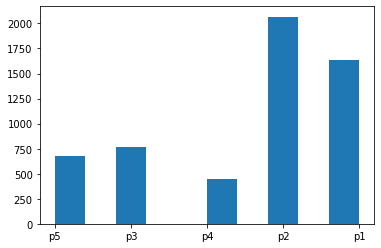

In [ ]:
# Show a distribution of the classes
plt.hist(df['profile_icon'])

In [ ]:
# Since the data is unbalanced, drop some p2 and p1 classes
df = df.drop(df.query('profile_icon == "p2"').sample(frac=.7).index)
df = df.drop(df.query('profile_icon == "p1"').sample(frac=.5).index)

In [ ]:
df.shape

(3329, 6)

(array([677.,   0., 769.,   0.,   0., 446.,   0., 620.,   0., 817.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

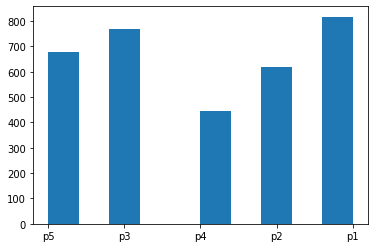

In [ ]:
plt.hist(df['profile_icon'])

In [ ]:
#Change the class strings to numbers, which is needed for training the model
class_dict = {'p1': 0,
              'p2': 1,
              'p3': 2,
              'p4': 3,
              'p5': 4}
df['profile_icon'] = df['profile_icon'].map(class_dict)

(array([817.,   0., 620.,   0.,   0., 769.,   0., 446.,   0., 677.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

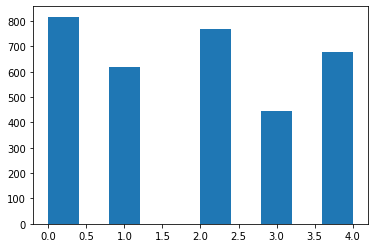

In [ ]:
plt.hist(df['profile_icon'])

In [ ]:
# There are some corrupt images that are not able to be transformed, therefore remove these
test_transform = data_transforms['test']
ind_errors = []
for ind, row in df.iterrows():
  try:
    im = Image.open(row['img_name'])
    test = test_transform(im)
  except Exception as e:
    ind_errors.append(ind)

df = df.drop(ind_errors)
df.shape

(3309, 6)

## Classification to predict profile icon

In [ ]:
# Split the data in a training and test set. In this case, 20% is used for testing and 80% is used for training.
test_set, train_set = test_train_split(df, 0.2, 0.8)

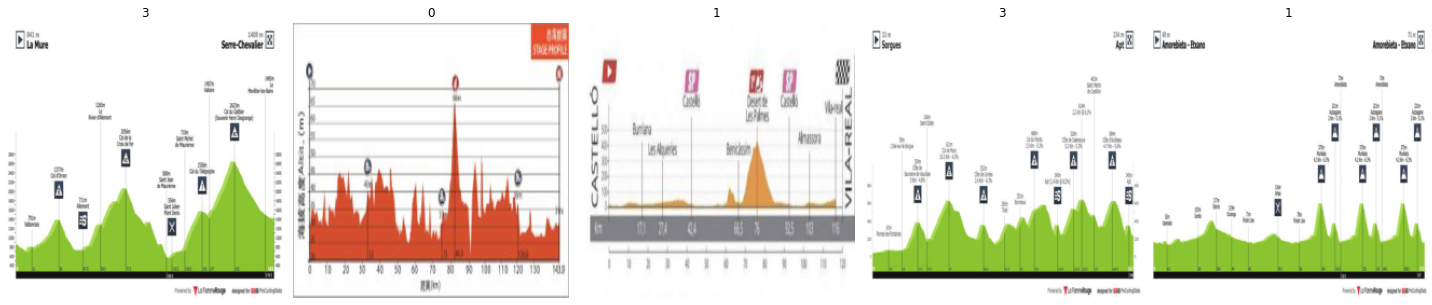

In [ ]:
# Show some example data
show_bunch(test_set, 5, column='profile_icon')

In [ ]:
# Load the test and training data in a data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
# Initialize a new model and send it to the GPU
model = new_model()
model.to(device)
pass # Prevent output

In [ ]:
# We use Cross Entropy loss as loss function.
criterion = torch.nn.CrossEntropyLoss()
# We use Adam as optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# Make the learning rate cyclic
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.00001, max_lr= 0.01, cycle_momentum=False)

In [ ]:
# Train the model
model, loss_history, val_loss_history = train_model(20, model, train_loader, test_loader, optimizer, criterion)

Epoch: 1
Epoch 0 MSE Train Loss: 0.0006030670057209564 ; Validation Loss: 1.9406496794202177.
Epoch: 2
Epoch 1 MSE Train Loss: 0.000593166780057474 ; Validation Loss: 1.5857282873366894.
Epoch: 3
Epoch 2 MSE Train Loss: 0.0007352583084999952 ; Validation Loss: 1.9253612103058853.
Epoch: 4
Epoch 3 MSE Train Loss: 0.0006516536407124829 ; Validation Loss: 1.5661073195610162.
Epoch: 5
Epoch 4 MSE Train Loss: 0.00047862119930484946 ; Validation Loss: 1.3588759547093843.
Epoch: 6
Epoch 5 MSE Train Loss: 0.0006796055845282958 ; Validation Loss: 1.3709777386949096.
Epoch: 7
Epoch 6 MSE Train Loss: 0.00017455410497973088 ; Validation Loss: 1.222852455390184.
Epoch: 8
Epoch 7 MSE Train Loss: 0.0007446023892761853 ; Validation Loss: 1.2824469007399733.
Epoch: 9
Epoch 8 MSE Train Loss: 0.0011147669138978642 ; Validation Loss: 1.203747913320169.
Epoch: 10
Epoch 9 MSE Train Loss: 0.00043481410472943373 ; Validation Loss: 1.0822498951883834.
Epoch: 11
Epoch 10 MSE Train Loss: 0.0002772222611874421 ; 

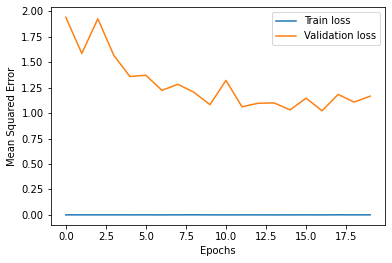

In [ ]:
# Show the losses
show_losses(loss_history, val_loss_history)

In [ ]:
# Show the accuracy on the test data
accuracy(model, test_loader)

Accuracy of the network is 56.95%.


In [ ]:
# Show the accuracy on the train data
accuracy(model, train_loader)

Accuracy of the network is 79.37%.


In [ ]:
# Save the model
model_save_name = 'profile_classifier.pt'
path = F"/content/content/My Drive/TdF/Profiles/more_data/{model_save_name}"
torch.save(model.state_dict(), path)